# 1.Importando Bibliotecas Essenciais.

In [ ]:
import pandas as pd #Manipulação de Dados em formato de tableas DataFrames
import numpy as np #trabalhar com arrays e cálculos númericos
import matplotlib.pyplot as plt #criar gráficos e vizulizar dados
import matplotlib.dates as mdates
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler #normalizar os dados em uma escala especifica

#ferramentas do Keras (dentro do TensorFlow) para construir redes neurais
from tensorflow.keras.models import Sequential #modelo sequencial (camada após camada)
from tensorflow.keras.layers import Dense, LSTM  #Dense = camada totalmente conectada; LSTM = Long Short-Term Memory, usada para séries temporais
from sklearn.metrics import mean_squared_error, mean_absolute_error #métricas para avaliar a performance do modelo
from tensorflow.keras.callbacks import EarlyStopping #treino automatico, quando a validação não melhora mais, evitando overfitting.

In [ ]:
#Fixando seed para garantir o mesmo resultado.
seed = 43
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# 2.Carregando o DataSet


In [ ]:
from google.colab import files #Importa apenas o módulo "files" da biblioteca google.colab
uploaded = files.upload()  #Abre uma janelinha no Colab pra você escolher e enviar um arquivo do seu PC

Saving PrecoMilho.xlsx to PrecoMilho (7).xlsx


# 3.Explorando e entendendo os dados

In [ ]:
df = pd.read_excel('PrecoMilho.xlsx') #Lê o arquivo Excel e transforma em um DataFrame do pandas
df #Exibe o conteúdo do DataFrame (padrão do Colab/Jupyter: última linha sem print já mostra)

,Data,À vista R$,À vista US$
0,02/08/2004,18.24,5.98
1,03/08/2004,18.04,5.91
2,04/08/2004,18.02,5.90
3,05/08/2004,18.06,5.89
4,06/08/2004,18.13,5.98
...,...,...,...
5167,06/05/2025,77.61,13.60
5168,07/05/2025,76.38,13.26
5169,08/05/2025,75.93,13.39
5170,09/05/2025,75.07,13.27


# 4.Convertendo coluna de datas para datetime

In [ ]:
#Converte a coluna 'Data' para o tipo datetime, usando o formato dia/mês/ano.
#Caso haja erro na conversão, substitui por NaT (valores nulos para datas).
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')

# 5. Dividindo o dataset em treino e teste


In [ ]:
# Definindo a porcentagem de dados para teste
test_size = 0.3  # 30% dos dados para teste

# Calculando o índice que separa treino de teste
split_index = int(len(df) * (1 - test_size))

# Separando os dados de treino e teste
train_data = df.iloc[:split_index]  # Tudo até o índice de corte vira treino
test_data = df.iloc[split_index:]   # O resto vira teste

# Só pra conferir o tamanho de cada conjunto
print(f"Tamanho treino: {len(train_data)}")
print(f"Tamanho teste: {len(test_data)}")

Tamanho treino: 3620
Tamanho teste: 1552


# 6.Normalizar a escala dos dados

In [ ]:
# Vamos usar só os dados de treino pra ajustar a escala, pra evitar "vazar" informação do teste

scaler = MinMaxScaler(feature_range=(-1, 1))  # escala entre -1 e 1

# Ajusta o scaler só no treino e transforma os valores do treino
treino_precos = train_data[['À vista R$']].values  # pega valores como array 2D (exigido pelo scaler)
treino_escala = scaler.fit_transform(treino_precos)

# Transforma os dados de teste usando o mesmo scaler, sem ajustar de novo!
teste_precos = test_data[['À vista R$']].values
teste_escala = scaler.transform(teste_precos)

# Pronto! Agora temos um 'train_scaled' e 'test_scaled' prontos pra usar no modelo.

# Só pra conferir o resultado
print("Exemplo treino normalizado:", treino_escala[:5])
print("Exemplo teste normalizado:", teste_escala[:5])

Exemplo treino normalizado: [[-0.75757576]
 [-0.7674304 ]
 [-0.76841587]
 [-0.76644494]
 [-0.76299581]]
Exemplo teste normalizado: [[0.39541759]
 [0.38507021]
 [0.38999754]
 [0.39591032]
 [0.42941611]]


# 7.Criando Janelas Temporais


In [ ]:
# Define o tamanho da janela de tempo (quantos dias anteriores usar pra prever o próximo)
tamanho_janela = 30  # Pode testar com outros valores depois, tipo 15, 60 etc.

def criar_janelas(dados, janela):
    X = []
    y = []
    for i in range(janela, len(dados)):
        X.append(dados[i-janela:i, 0])  # pega os 'janela' valores anteriores
        y.append(dados[i, 0])           # pega o valor atual como target
    return np.array(X), np.array(y)

# Cria janelas para treino e teste
X_treino, y_treino = criar_janelas(treino_escala, tamanho_janela)
X_teste, y_teste = criar_janelas(teste_escala, tamanho_janela)

# O LSTM espera os dados no formato [amostras, time steps, features]
X_treino = X_treino.reshape((X_treino.shape[0], X_treino.shape[1], 1))
X_teste = X_teste.reshape((X_teste.shape[0], X_teste.shape[1], 1))

# Só pra conferir
print("Formato X_treino:", X_treino.shape)
print("Formato y_treino:", y_treino.shape)

Formato X_treino: (3590, 30, 1)
Formato y_treino: (3590,)


# 8.Construir o modelo LSTM


In [ ]:
# Criar o modelo sequencial
model = Sequential()

# Adicionar a camada LSTM (50 neurônios)
model.add(LSTM(units=100, input_shape=(X_treino.shape[1], X_treino.shape[2])))

# Adicionar a camada densa de saída (1 neurônio)
model.add(Dense(1))

print("Modelo criado, mas ainda NÃO compilado.")
model.summary()

Modelo criado, mas ainda NÃO compilado.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

# 9.Compilando o modelo


In [ ]:
# Compilar o modelo
model.compile(loss='mean_squared_error', optimizer='adam')

print("Modelo compilado e pronto pra treinar!")

Modelo compilado e pronto pra treinar!


# 10.Treinando o modelo

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',    # O que ele vai observar
    patience=5,            # Quantas epochs sem melhora antes de parar
    restore_best_weights=True  # Recupera os melhores pesos
)

history = model.fit(
    X_treino, y_treino,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0298 - val_loss: 0.0036
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.1071e-04 - val_loss: 0.0029
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.5483e-04 - val_loss: 0.0024
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.6111e-04 - val_loss: 0.0023
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0303e-04 - val_loss: 0.0021
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 4.5764e-04 - val_loss: 0.0019
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.2096e-04 - val_loss: 0.0018
Epoch 9/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.8851e-04 - val_loss: 0.0017
Epoch 10/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.5866e-04 - val_loss: 0.0016
Epoch 11/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.3147e-04 - val_loss: 0.0015
Epoch 12/40
90/90 ━━━━━━━━━

# 11.Avaliando a perda durante os testes

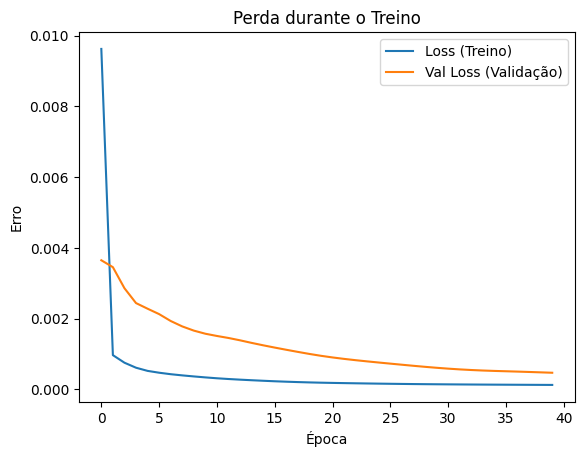

In [ ]:
# history é o retorno do model.fit()
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Val Loss (Validação)')
plt.title('Perda durante o Treino')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()
plt.show()

# 12.Fazendo previsões com dados de Teste

In [ ]:
# Fazer previsões usando os dados de teste preparados (janelas temporais)
y_pred_escala = model.predict(X_teste)  # previsão ainda normalizada (-1 a 1)

# Desnormalizar os valores previstos (voltar para escala original)
y_pred = scaler.inverse_transform(y_pred_escala)

# Também desnormalizar os valores reais do y_teste pra comparação
y_real = scaler.inverse_transform(y_teste.reshape(-1, 1))

# Mostrar os primeiros 5 valores previstos vs reais
for i in range(5):
    print(f"Previsto: {y_pred[i][0]:.2f} - Real: {y_real[i][0]:.2f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Previsto: 38.41 - Real: 38.32
Previsto: 38.54 - Real: 38.08
Previsto: 38.34 - Real: 37.39
Previsto: 37.65 - Real: 37.10
Previsto: 37.01 - Real: 37.01


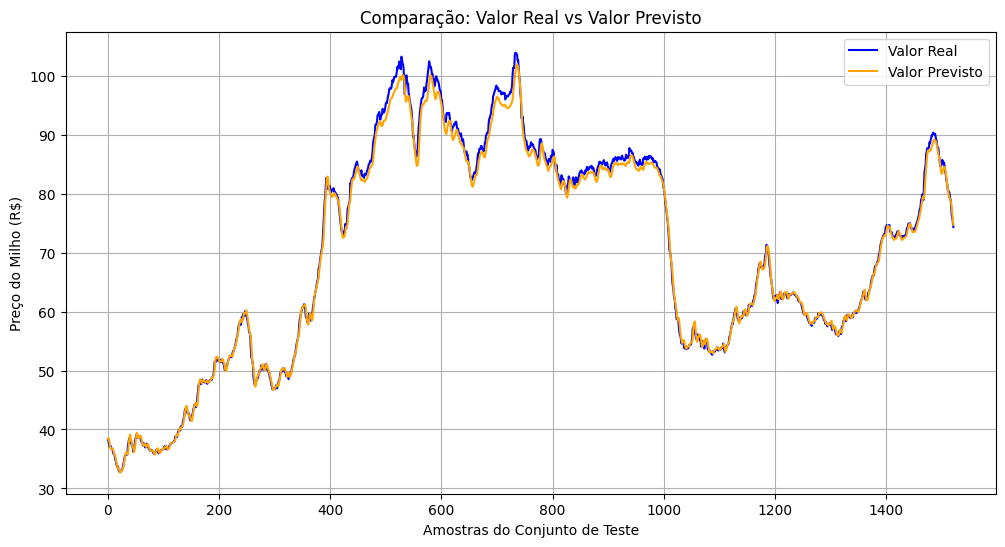

In [ ]:
# Plotando o gráfico para comparação
plt.figure(figsize=(12, 6))
plt.plot(y_real, label='Valor Real', color='blue')
plt.plot(y_pred, label='Valor Previsto', color='orange')
plt.title('Comparação: Valor Real vs Valor Previsto')
plt.xlabel('Amostras do Conjunto de Teste')
plt.ylabel('Preço do Milho (R$)')
plt.legend()
plt.grid(True)
plt.show()

# 14.Avaliando a performace do modelo

In [ ]:
# y_pred - previsões do modelo (normalizadas revertidas)
# y_real - valores reais (normalizados revertidos)

rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mae = mean_absolute_error(y_real, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 1.0793
MAE: 0.7790


# 15.Plotando Gráfico final

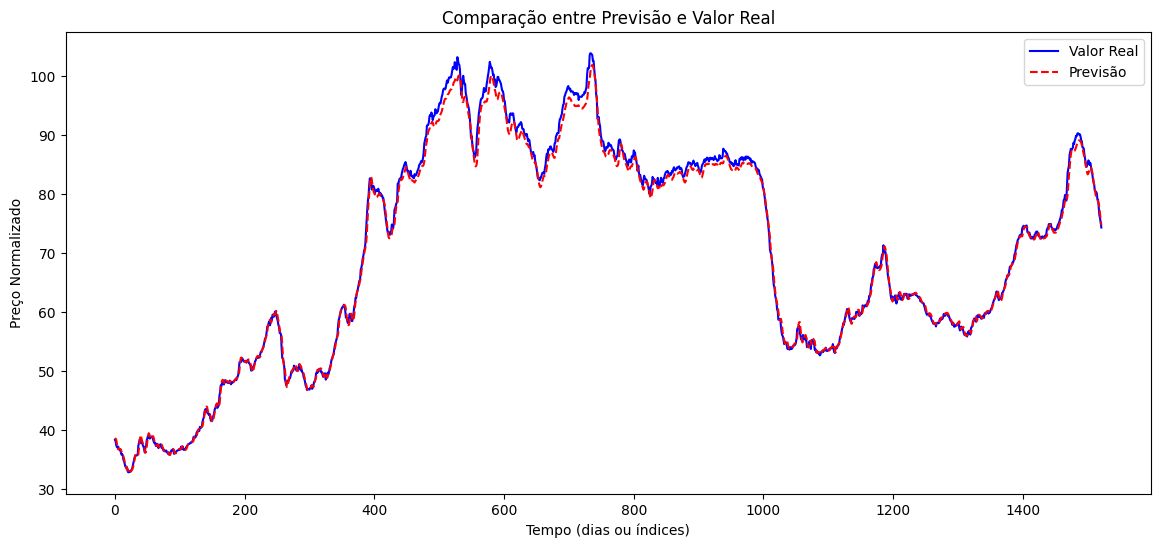

In [ ]:
# 'y_real' são os valores reais (desnormalizados)
# 'y_pred' são as previsões do modelo (desnormalizadas)

plt.figure(figsize=(14,6))
plt.plot(y_real, label='Valor Real', color='blue')
plt.plot(y_pred, label='Previsão', color='red', linestyle='--')
plt.title('Comparação entre Previsão e Valor Real')
plt.xlabel('Tempo (dias ou índices)')
plt.ylabel('Preço Normalizado')
plt.legend()
plt.show()

# 16.Normalizando o Gráfico

In [ ]:
# Supondo que separomos 70% treino e 30% teste
tamanho_janela = 30
porcentagem_treino = 0.7
tamanho_treino = int(len(df) * porcentagem_treino)

# Recuperando as datas do conjunto de teste com base no índice
datas_teste = df['Data'].values[tamanho_treino + tamanho_janela:]

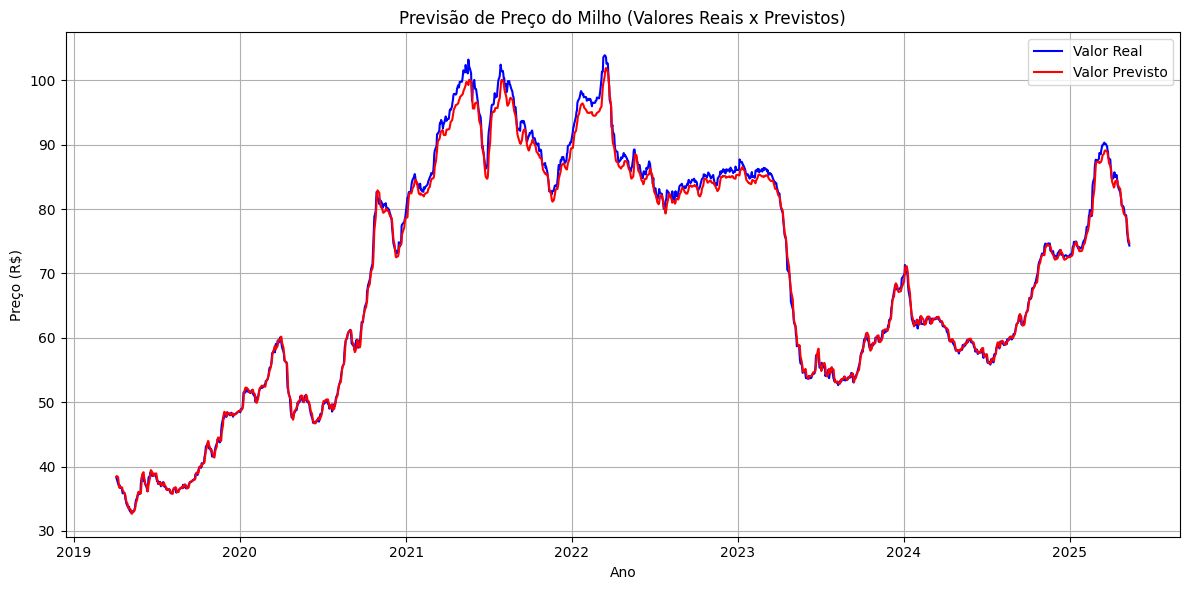

In [ ]:
# Criando uma série de anos para o eixo x

datas_formatadas = pd.to_datetime(datas_teste)


plt.figure(figsize=(12, 6))
plt.plot(datas_formatadas, y_real.flatten(), label='Valor Real', color='blue')
plt.plot(datas_formatadas, y_pred.flatten(), label='Valor Previsto', color='red')

# Formatação do eixo X para mostrar os anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.title('Previsão de Preço do Milho (Valores Reais x Previstos)')
plt.xlabel('Ano')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 17.Prevendo dados Futuros


In [ ]:
# Supondo que X_teste seja o último batch de janelas com dados atuais

num_dias_futuros = 10
previsoes_futuras = []

ultimo_batch = X_teste[-1]  # Pega a última janela do teste (formato (30,1))

for _ in range(num_dias_futuros):
    # Modelo prevê o próximo valor com base na última janela
    pred = model.predict(ultimo_batch.reshape(1, 30, 1))

    # Salva a previsão
    previsoes_futuras.append(pred[0,0])

    # Atualiza a janela: remove o primeiro valor e adiciona o previsto
    ultimo_batch = np.append(ultimo_batch[1:], pred[0,0])
    ultimo_batch = ultimo_batch.reshape(30, 1)

# Desnormaliza as previsões para ficar em reais (se você normalizou antes)
previsoes_futuras_reais = scaler.inverse_transform(np.array(previsoes_futuras).reshape(-1,1))

print(previsoes_futuras_reais)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[74.71075 ]
 [74.01378 ]
 [73.40292 ]
 [72.8771  ]
 [72.4257  ]
 [72.037964]
 [71.70398 ]
 [71.41573 ]
 [71.16731 ]
 [70.95363 ]]


# 18.Plotando gráfico das previsões

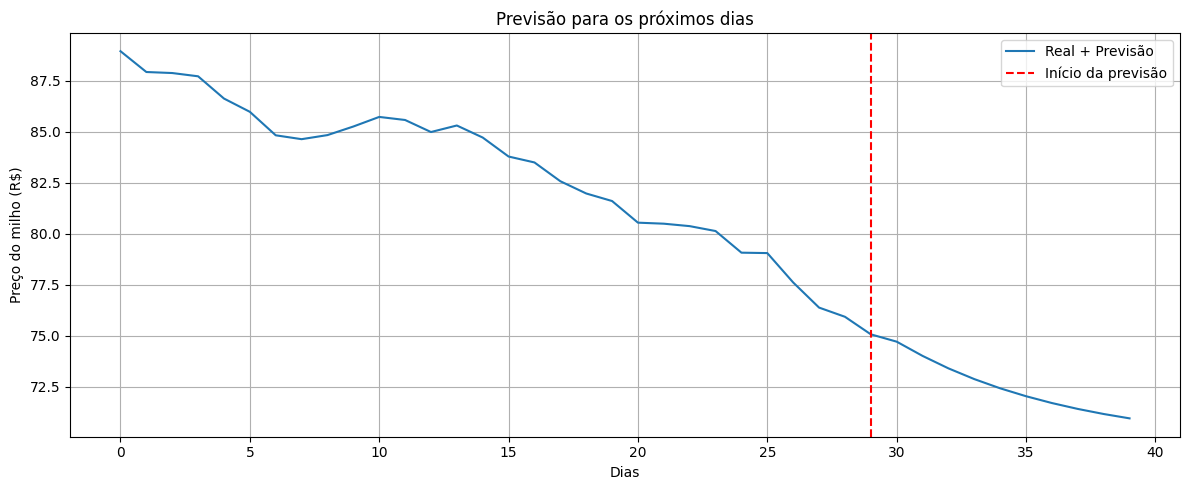

In [ ]:
# Últimos valores reais do dataset (por exemplo, os últimos 30 dias reais)
# Você pode ajustar isso com base no que tiver
ultimos_reais = scaler.inverse_transform(X_teste[-1].reshape(-1, 1))

# Junta os reais + futuros previstos
tudo = np.concatenate((ultimos_reais, previsoes_futuras_reais), axis=0)

# Cria eixo X com marcações de dias
dias = list(range(len(tudo)))
linha_divisao = len(ultimos_reais)  # separa o que é real e o que é previsão

# Plota
plt.figure(figsize=(12, 5))
plt.plot(dias, tudo, label='Real + Previsão')
plt.axvline(x=linha_divisao - 1, color='red', linestyle='--', label='Início da previsão')
plt.title('Previsão para os próximos dias')
plt.xlabel('Dias')
plt.ylabel('Preço do milho (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 19.Tabela de comparação

In [ ]:
# Lê a tabela do Excel
df = pd.read_excel('/content/ComparacaoMilho.xlsx')

df

,DATA:,VALORES REAIS:,VALORES PREVISTOS,ERRO,ERRO²,MSE
0,13/05/2025,73.57,74.71,-1.14,1.2996,0.28154
1,14/05/2025,73.12,74.01,-0.89,0.7921,NaN
2,15/05/2025,73.07,73.40,-0.33,0.1089,NaN
3,16/05/2025,72.93,72.87,0.06,0.0036,NaN
4,19/05/2025,72.68,72.42,0.26,0.0676,NaN
5,20/05/2025,72.59,72.03,0.56,0.3136,NaN
6,21/05/2025,72.03,71.70,0.33,0.1089,NaN
7,22/05/2025,71.22,71.41,-0.19,0.0361,NaN
8,23/05/2025,71.13,71.16,-0.03,0.0009,NaN
9,26/05/2025,71.24,70.95,0.29,0.0841,NaN
